In [37]:
# Importando bibliotecas
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import locale
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import ScalarFormatter

In [56]:
import pandas as pd
import os

# Definindo o caminho
rootPath = os.getcwd()
#print(rootPath)

caminho = rootPath 
df_1 = pd.read_csv(caminho + '\\METEO.csv')
# Renomeando as colunas
df_1.columns = [
    "ano", "mes", "dia", "dia juliano", "hora", "calor sensível",
    "surface friction velocity", "convective velocity scale",
    "potential temperature", "convectively-driven mixing height",
    "mechanically-driven mixing height", "Monin-Obukhov length",
    "rugosidade", "bowen", "albedo", "velocidade de vento",
    "direcao de vento", "anenometro", "temperatura",
    "medida de medida da temperatura", "codigo de precipitacao",
    "quantidade de precipitacao", "umidade relativa", "pressao (mb)",
    "cobertura de nuvens", "velocidade vento", "cobertura de nuvem"]

#print(df_1.head())

df_2 = pd.read_csv(caminho + '\\EZ_AERMOD_biancasuganuma_2024-07-02_WROCK_MP\\RANK_15.csv')

df_2.columns = ['rank', 'conc', 'ano', 'mes', 'dia', 'x', 'y', 'ZELEV', 'ZHILL', 'ZFLAG', 'GRP']

#print(df_2.head())

# Verificando se as colunas ano, mes e dia estão presentes em ambos os DataFrames
required_columns = ['ano', 'mes', 'dia']

for col in required_columns:
    if col not in df_1.columns:
        raise ValueError(f"Coluna {col} não encontrada em df_1")
    if col not in df_2.columns:
        raise ValueError(f"Coluna {col} não encontrada em df_2")

# Convertendo colunas para o tipo inteiro, se necessário
df_1['ano'] = df_1['ano'].astype(int)
df_1['mes'] = df_1['mes'].astype(int)
df_1['dia'] = df_1['dia'].astype(int)

df_2['ano'] = df_2['ano'].astype(int)
df_2['mes'] = df_2['mes'].astype(int)
df_2['dia'] = df_2['dia'].astype(int)

# Verificando se há valores ausentes nas colunas de ano, mes e dia
if df_1[['ano', 'mes', 'dia']].isnull().any().any():
    raise ValueError("Valores ausentes encontrados em df_1 nas colunas ano, mes ou dia")
if df_2[['ano', 'mes', 'dia']].isnull().any().any():
    raise ValueError("Valores ausentes encontrados em df_2 nas colunas ano, mes ou dia")

# Criando uma chave única para comparação combinando as colunas ano, mes e dia
df_1['chave'] = df_1['ano'].astype(str) + '-' + df_1['mes'].astype(str) + '-' + df_1['dia'].astype(str)
df_2['chave'] = df_2['ano'].astype(str) + '-' + df_2['mes'].astype(str) + '-' + df_2['dia'].astype(str)

# Filtrando df_1 para incluir apenas as datas comuns encontradas em df_2
df_1_comum = df_1[df_1['chave'].isin(df_2['chave'])].copy()

# Removendo a coluna chave, se não for necessária mais
df_1_comum.drop(columns=['chave'], inplace=True)

print("Novo DataFrame com as datas em comum:")
print(df_1_comum)

Novo DataFrame com as datas em comum:
      ano  mes  dia  dia juliano  hora  calor sensível  \
288    23    1   13           13     1           -43.8   
289    23    1   13           13     2           -43.8   
290    23    1   13           13     3           -51.8   
291    23    1   13           13     4           -45.2   
292    23    1   13           13     5           -12.3   
...   ...  ...  ...          ...   ...             ...   
8707   23   12   29          363    20            -1.8   
8708   23   12   29          363    21            -5.2   
8709   23   12   29          363    22           -38.9   
8710   23   12   29          363    23           -64.0   
8711   23   12   29          363    24           -64.0   

      surface friction velocity  convective velocity scale  \
288                       0.432                       -9.0   
289                       0.432                       -9.0   
290                       0.510                       -9.0   
291              

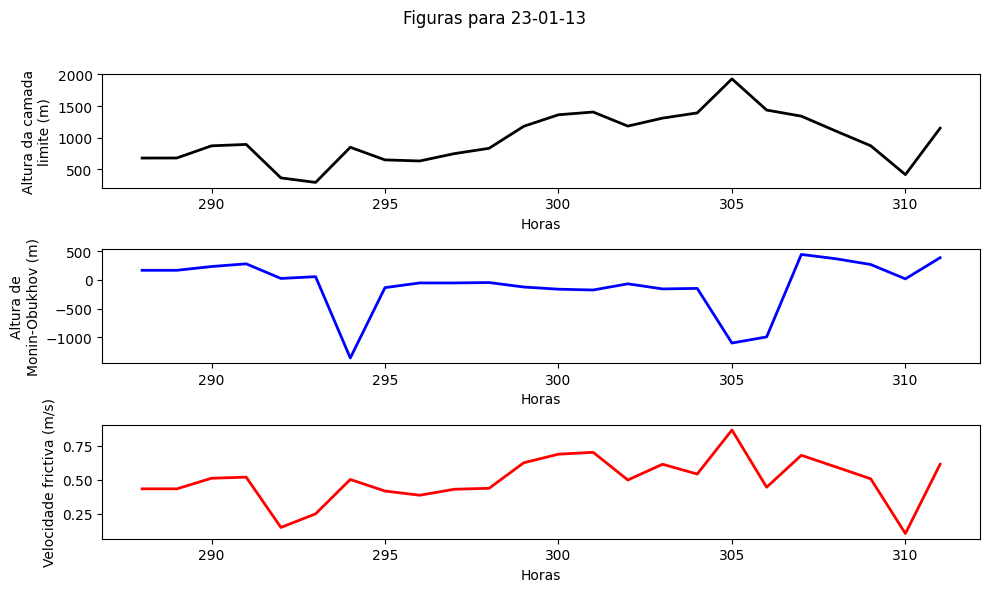

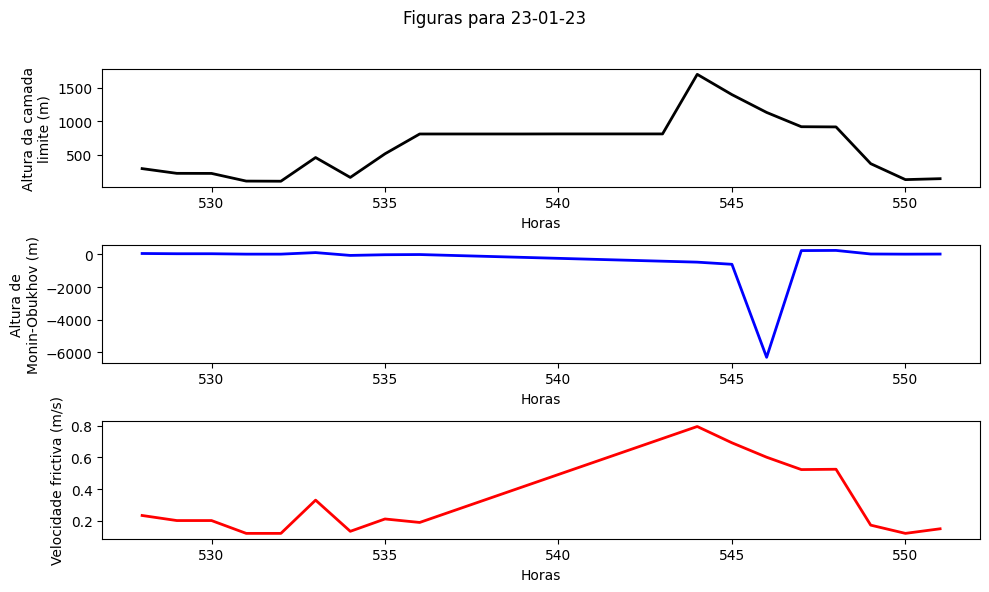

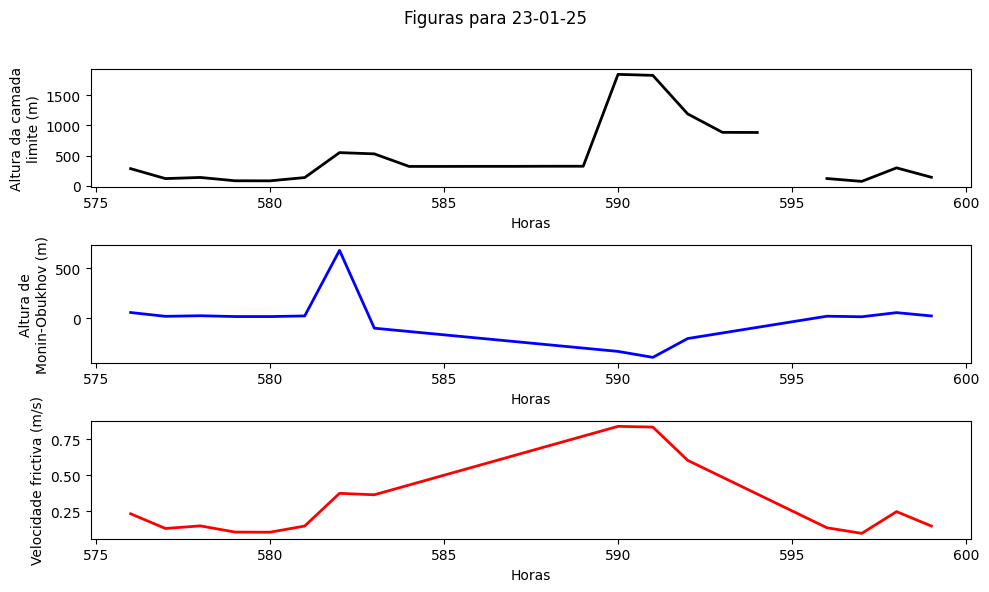

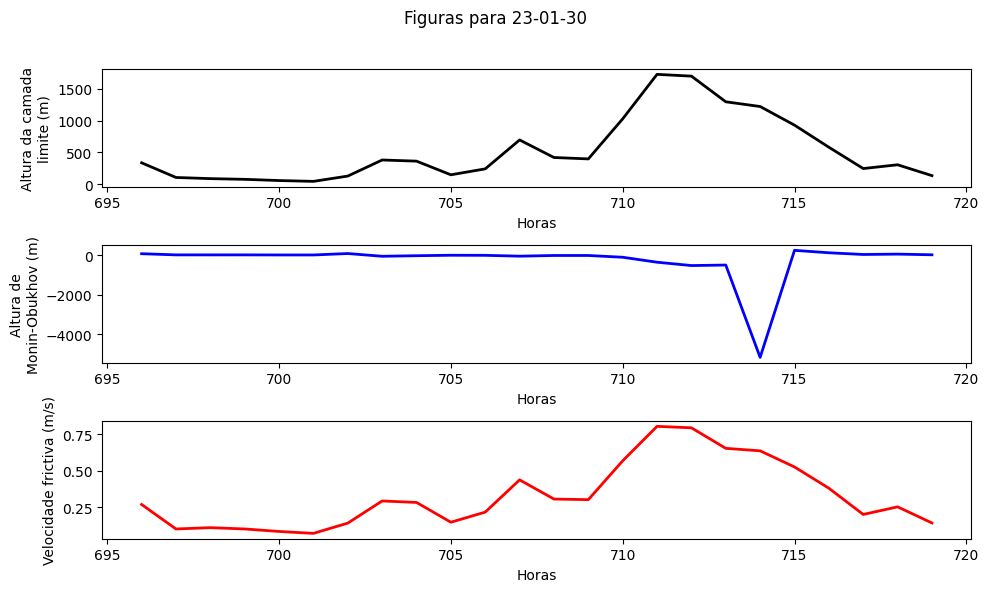

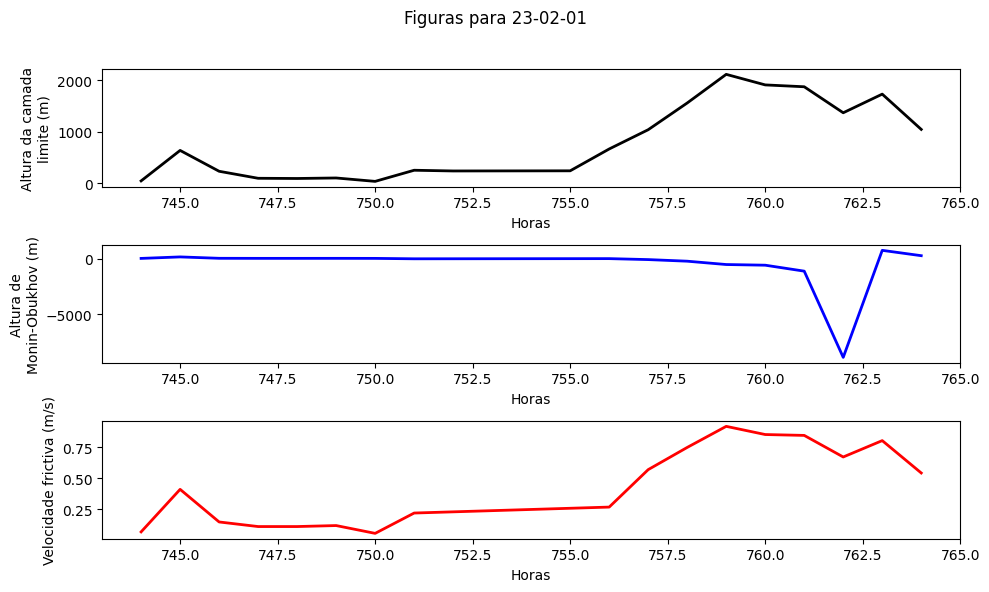

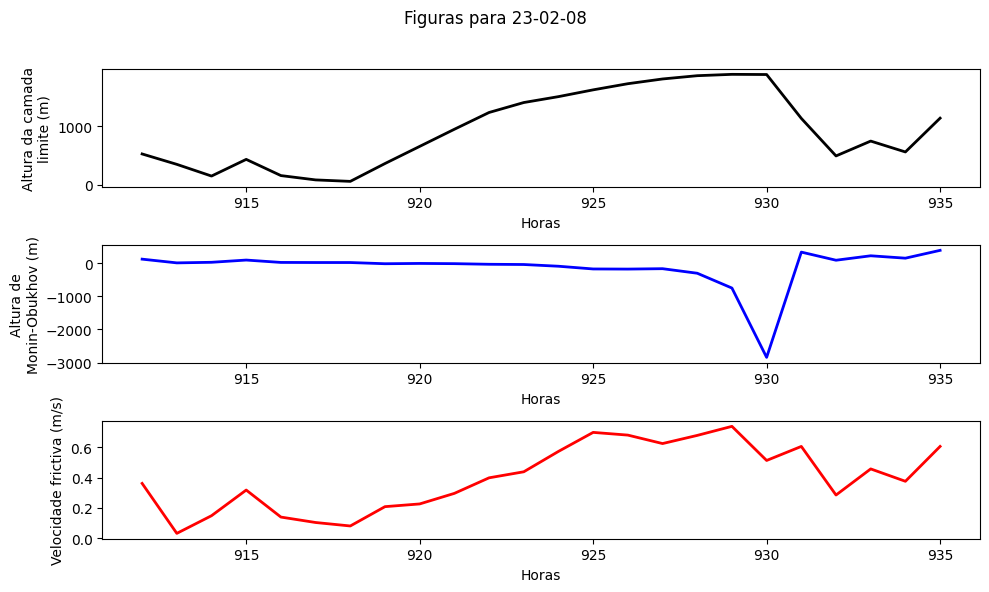

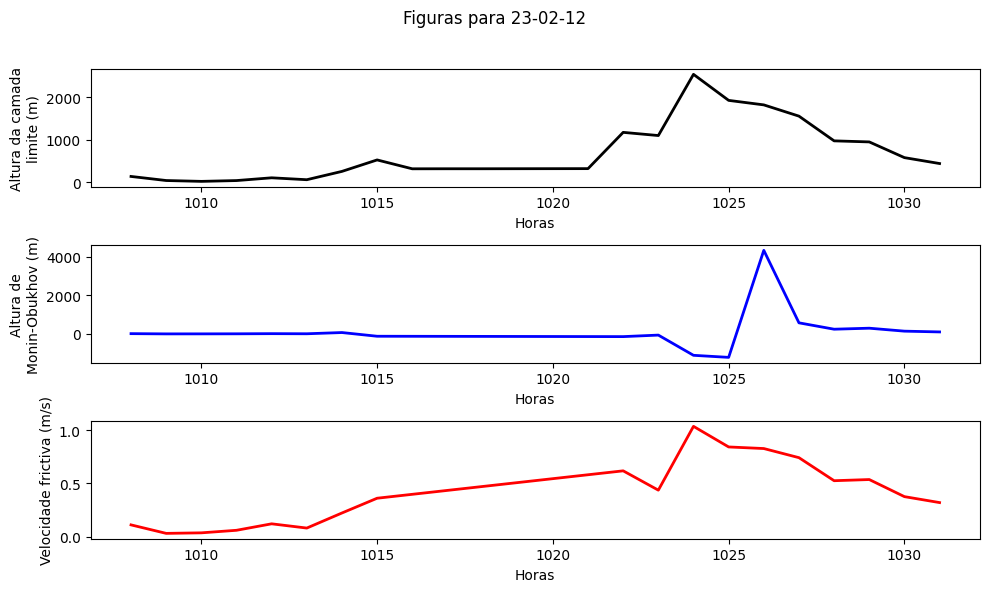

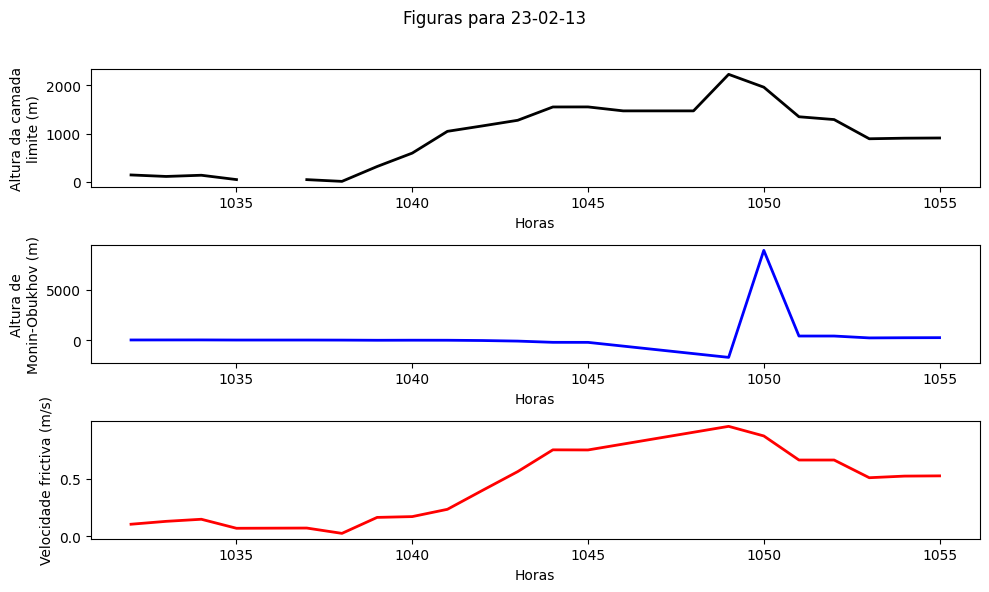

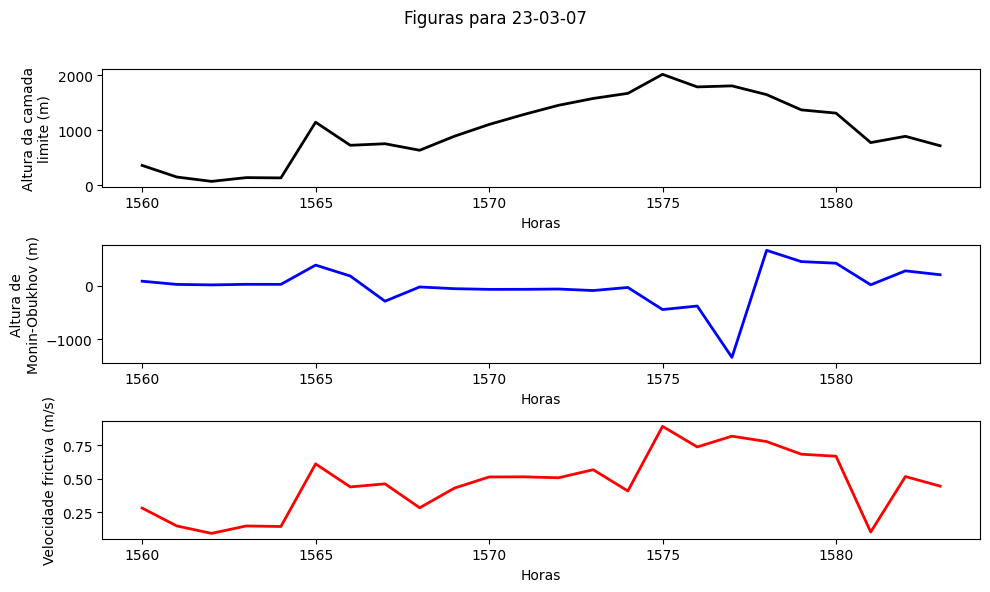

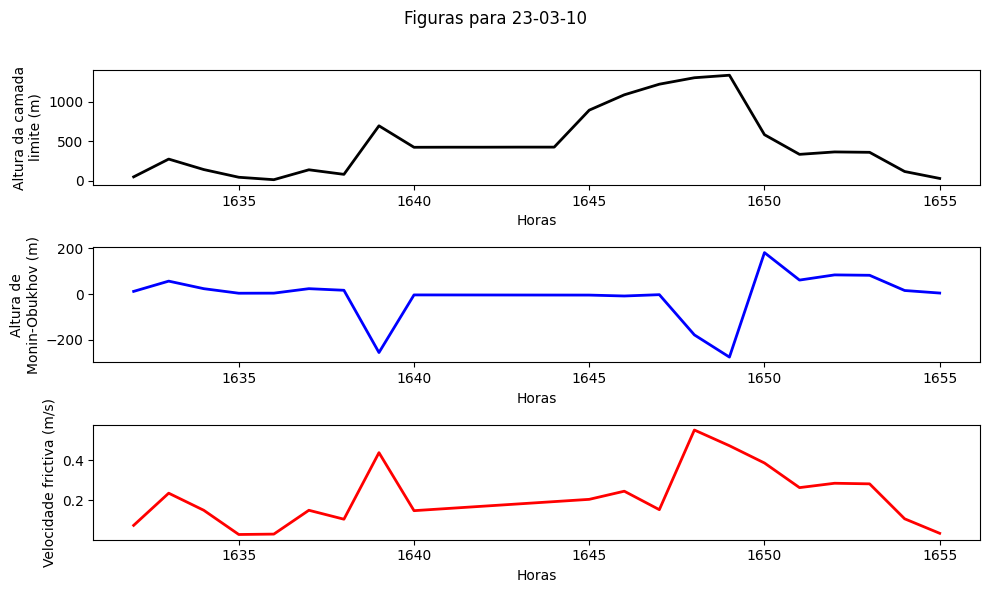

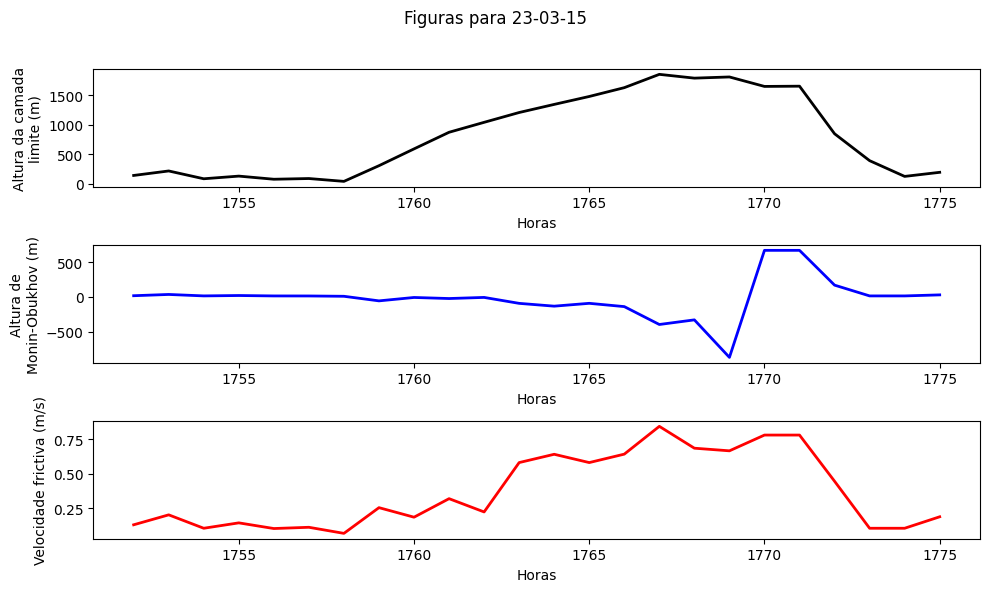

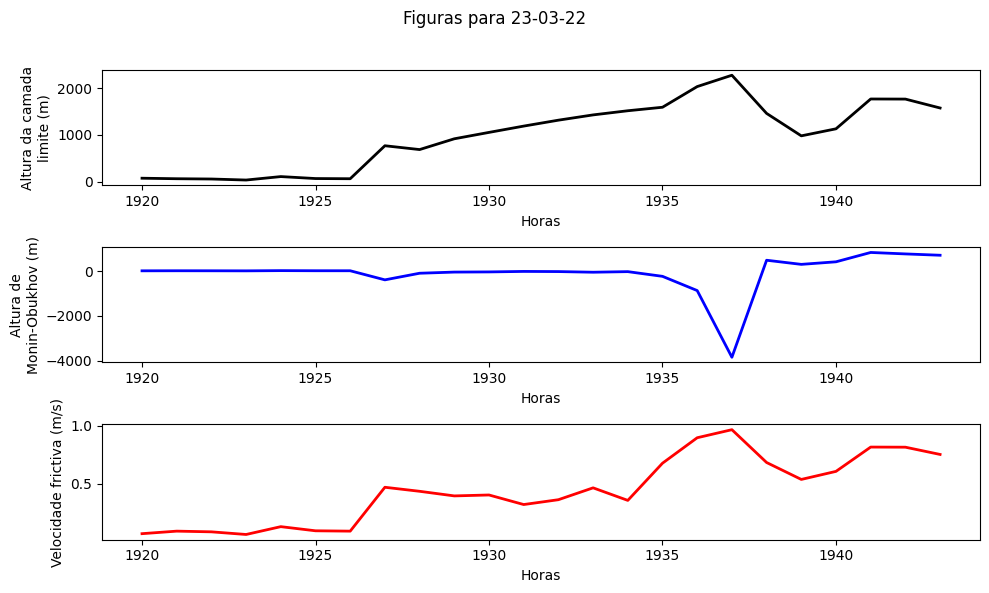

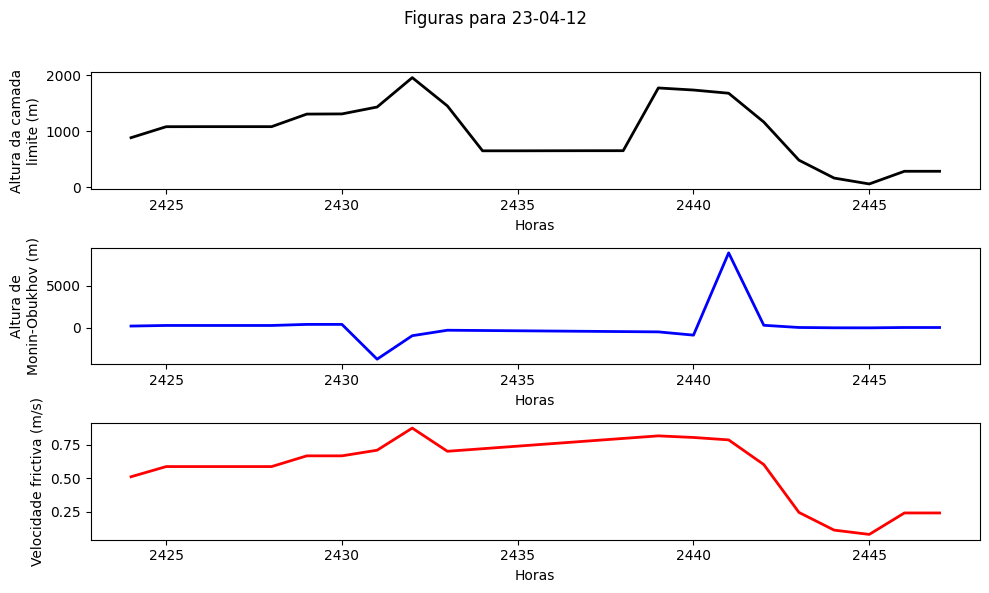

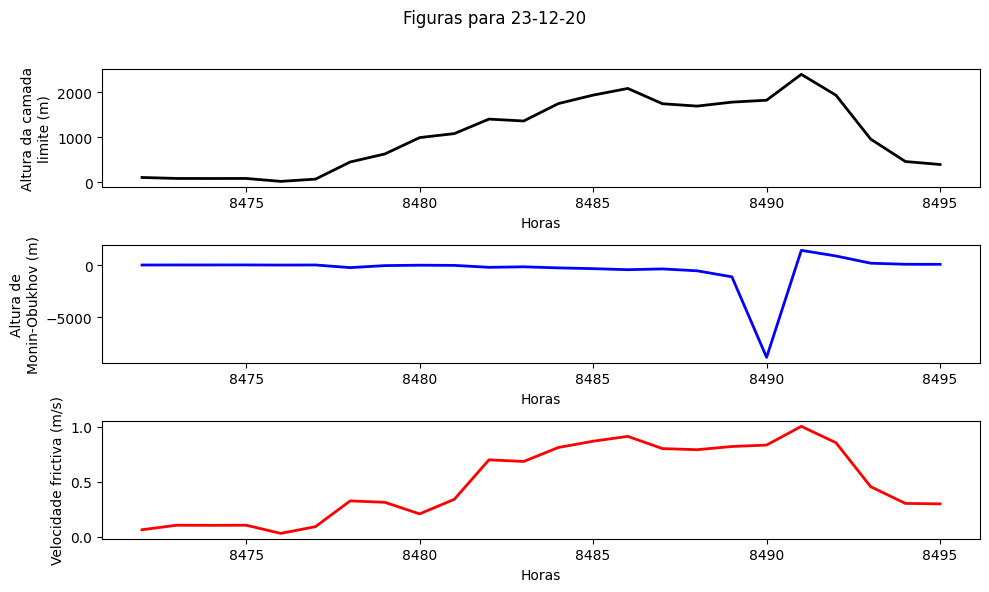

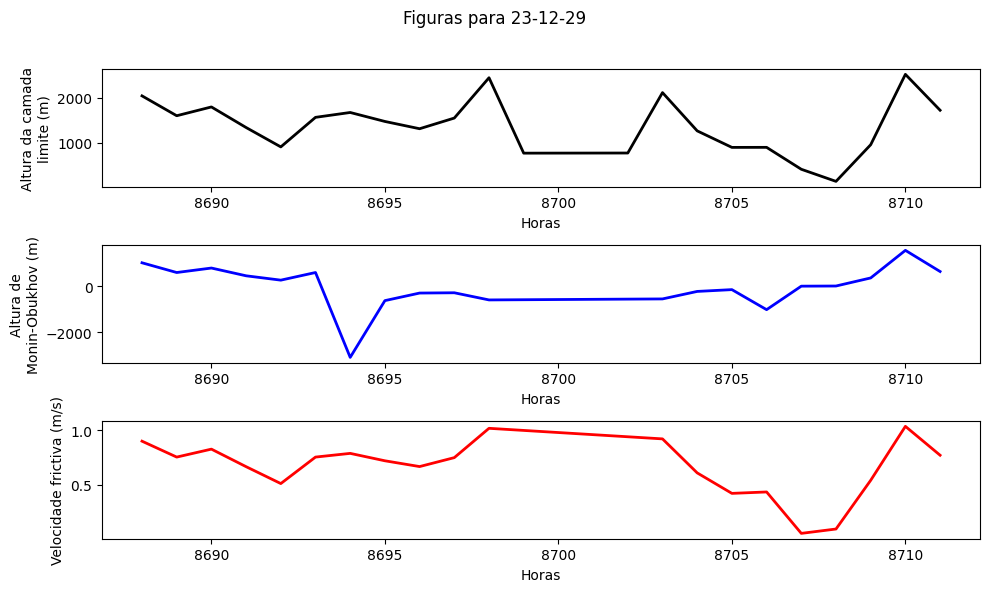

In [57]:
# Função auxiliar para encontrar o maior valor, ignorando valores negativos
def maior_valor(row):
    val1 = row["convectively-driven mixing height"]
    val2 = row["mechanically-driven mixing height"]
    # Filtra valores negativos
    valores = [val for val in [val1, val2] if val >= 0]
    if valores:
        return max(valores)
    else:
        return None  # ou algum valor padrão como NaN

# Aplicando a função a cada linha do DataFrame
df_1_comum['camada_limite'] = df_1_comum.apply(maior_valor, axis=1)

# Filtrando datas únicas
datas_unicas = df_1_comum[['ano', 'mes', 'dia']].drop_duplicates()

for _, data in datas_unicas.iterrows():
    ano, mes, dia = data['ano'], data['mes'], data['dia']
    
    df_dia = df_1_comum[(df_1_comum['ano'] == ano) & (df_1_comum['mes'] == mes) & (df_1_comum['dia'] == dia)]
    
    # Criando figura com o valor da camada limite bruta
    fig, ax = plt.subplots(3, 1, figsize=(10, 6))

    ax[0].plot(df_dia['camada_limite'], linewidth=2, color='black')
    ax[0].set_ylabel('Altura da camada\nlimite (m)')
    ax[0].set_xlabel('Horas')

    # Criando figura com o valor da altura de Monin-Obukhov
    ax[1].plot(df_dia[df_dia['Monin-Obukhov length'] != -99999]['Monin-Obukhov length'], linewidth=2, color='blue')
    ax[1].set_ylabel('Altura de\nMonin-Obukhov (m)')
    ax[1].set_xlabel('Horas')

    # Criando figura de velocidade frictiva
    ax[2].plot(df_dia[df_dia['surface friction velocity'] != -9]['surface friction velocity'], linewidth=2, color='red')
    ax[2].set_ylabel('Velocidade frictiva (m/s)')
    ax[2].set_xlabel('Horas')
    
    # Adicionando a data como título do gráfico
    data_titulo = f'{ano}-{mes:02d}-{dia:02d}'
    fig.suptitle(f'Figuras para {data_titulo}')
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    # Salvar ou mostrar a figura
    plt.savefig(f'figuras_{ano}_{mes:02d}_{dia:02d}.png')
    plt.show()